# Plastic or Glass? - Image Classication with Deep Learning
###### METIS Data Science and Machine Learning Bootcamp 2022 by Krystian Krystkowiak
###### project/month(6/7) focus: DEEP LEARNING

ABSTRACT

- Developed a deep learning model to classify glass and plastic waste photos (Kaggle
competition dataset) using Tensor Flow and Keras, testing various models including Neural Networks, Convolutional Neural Networks, and Transfer learning with pre-trained models such as VGG16, VGG19, and Xception. Achieved a high F1 score of 90% with the CNN model.

### EDA/preprocessing/data load

In [8]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re

from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [9]:
#setting data source

DIR_PATH = os.path.abspath("garbage_classification/")
folders = os.listdir(DIR_PATH)
folders.pop(0) #removing .DS_Store
folders

['green-glass', 'white-glass', 'brown-glass', 'plastic']

In [10]:
# finding the largest image shape for reference
# to select the right target size

max_img_size = 0
max_img_shape = None

for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)

        img = load_img(img_path)
        img_shape = img_to_array(img).shape
        width, height, __ = img_shape
        curr_img_size = width * height
        
        if curr_img_size > max_img_size or not max_img_size:
            max_img_size = curr_img_size
            max_img_shape = img_shape
            
max_img_shape

(384, 512, 3)

In [17]:
#function of resizing and padding images to be used later in the model 

TARGET_HEIGHT = 128
TARGET_WIDTH = 128

def preprocess_img_to_arr(img, target_height = TARGET_HEIGHT, target_width = TARGET_WIDTH):
    img_arr = np.asarray(img)
    img_tensor = tensorflow.convert_to_tensor(img_arr)

    # new_img_arr = resize_with_pad(
    #     img_tensor, 
    #     target_height, 
    #     target_width, 
    #     method = 'bicubic',
    #     antialias = True
    # )
    
    return img_tensor

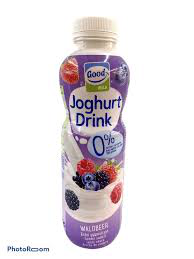

In [18]:
img = load_img('garbage_classification/plastic/plastic1.jpg')
img

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-26 15:11:02.419056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-26 15:11:02.419800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


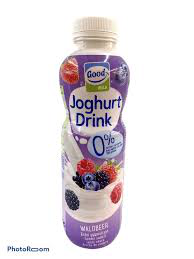

In [19]:
array_to_img(preprocess_img_to_arr(img))

In [20]:
# store preprocessed images in new folder
NEW_DIR_PATH = os.path.abspath('new_images')

for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    new_folder_path = os.path.join(NEW_DIR_PATH, folder)
    
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)
    
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)
        new_img_path = os.path.join(new_folder_path, img)
        
        img = load_img(img_path)
        img_arr = preprocess_img_to_arr(img)
        save_img(new_img_path, img_arr)


In [21]:
# creating a generator for the images

datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True)

generator = datagen.flow_from_directory(
    'new_images',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 32,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True)

Found 2876 images belonging to 4 classes.


In [22]:
# cleaning the names of the classes

def clean_name(name):
    name = (
        re
        .sub(r'\d+', '', name) # remove digits
        .strip() # remove whitespace
    )
    return name


label_to_name_dict = {label: clean_name(name) for name, label in generator.class_indices.items()}
label_to_name_dict

{0: 'brown-glass', 1: 'green-glass', 2: 'plastic', 3: 'white-glass'}

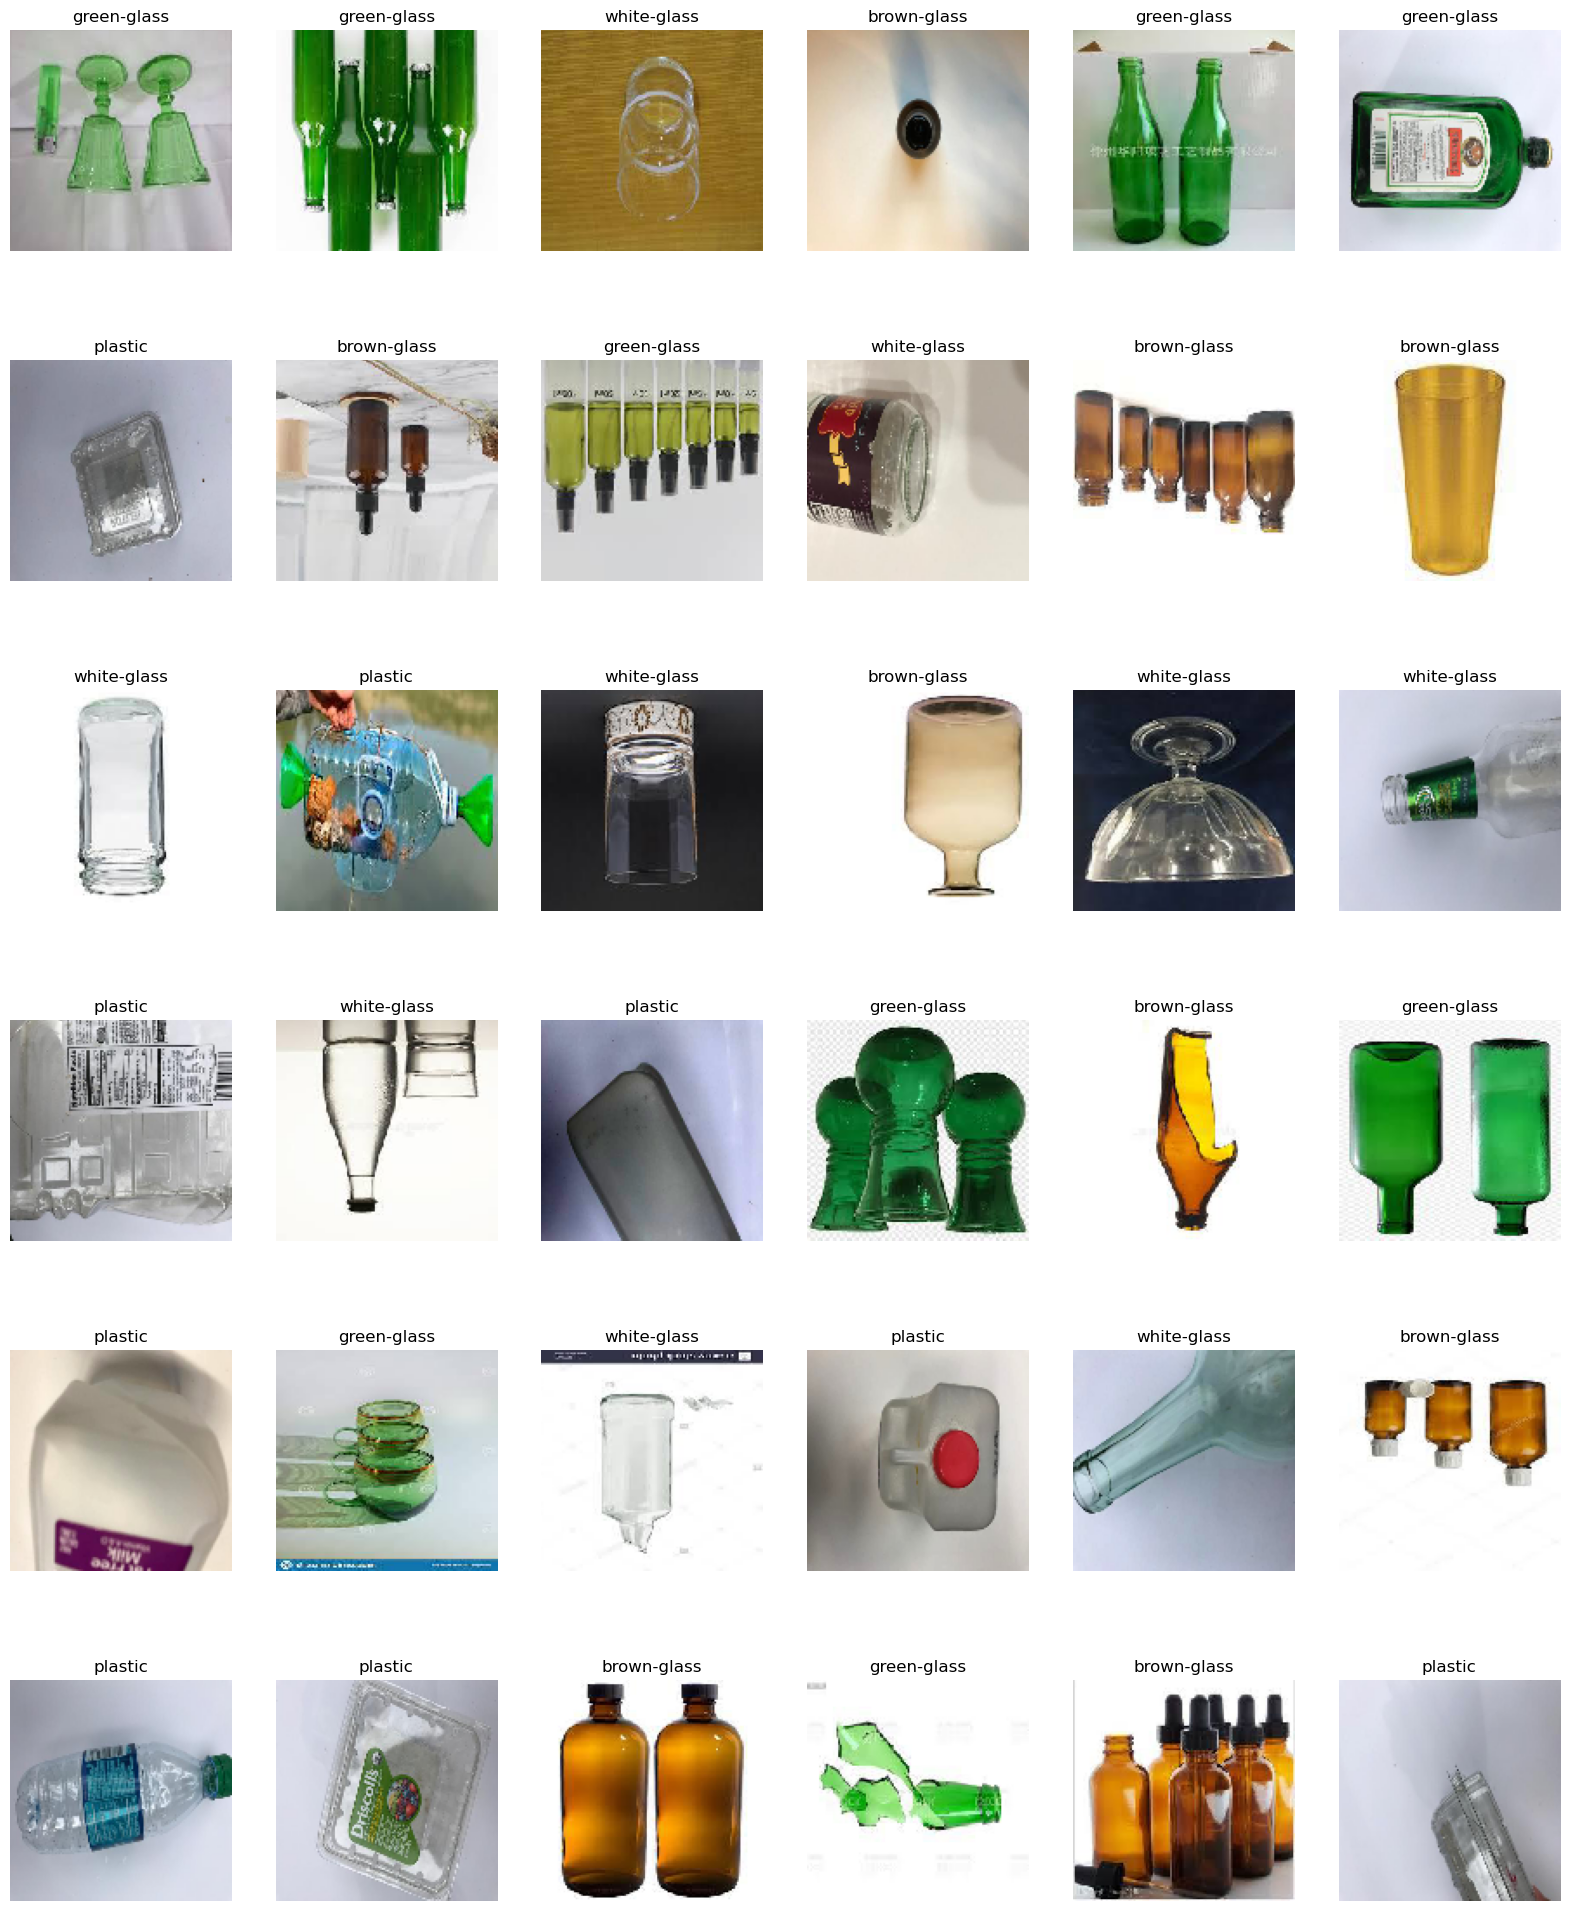

In [23]:
# sample a few images
num_rows, num_cols = 6, 6
num_imgs = num_rows * num_cols

plt.figure(figsize=(20, 25))

# these images can be used for both non-deep-learning and deep-learning applications
for idx in range(num_imgs):
    img, label_arr = generator.next()
    label = np.argmax(label_arr)
    name = label_to_name_dict[label]
    plt.subplot(num_rows, num_cols, idx + 1, title = name)

    plt.imshow(img[0])
    plt.axis('off')

In [24]:
#counting the number of images in each class

for folder in folders:
    folder_path = os.path.join(NEW_DIR_PATH, folder)
    imgs = os.listdir(folder_path)
    print(f"{folder}: {len(imgs)}")


green-glass: 629
white-glass: 775
brown-glass: 607
plastic: 865


Images are ready to be loaded into the dataframe. There are a total of 2527 images, with 865 plastic images and 1662 glass images. There is a class imbalance present which can be addressed later.

In [25]:
#data loading and preprocessing for the model

img_array=[]
class_name=[]
img_name=[]

def create_image_df(img_folder): # path_resized_baseline_train
   
    for img_class_subfolder in os.listdir(img_folder):
        if img_class_subfolder == '.DS_Store':
            continue
        for file in os.listdir(os.path.join(img_folder, img_class_subfolder)):
       
            image_path= os.path.join(img_folder, img_class_subfolder,  file)
            
            img = tensorflow.keras.utils.load_img(image_path, target_size=(128,128),color_mode = "rgb")
            x = tensorflow.keras.utils.img_to_array(img)
            x = x/255
            x = np.expand_dims(x, axis=0)
            x = np.transpose(x.flatten())
            
            # append to list
            img_array.append(x)
            class_name.append(img_class_subfolder)
            img_name.append(file)
    
    # create df and concatenate 3 elements
    df_img_array = pd.DataFrame(data = img_array)
    df_name = pd.DataFrame({'img_id':img_name})    
    df_class = pd.DataFrame({'class_name':class_name})
            
    # merge dataframes
    img_df_temp = df_img_array.merge(df_name, left_index=True, right_index=True)
    img_df = img_df_temp.merge(df_class, left_index=True, right_index=True)
               
    return img_df

In [26]:
df = create_image_df(NEW_DIR_PATH)

In [27]:
#df with the images and their classes
df

,0,1,2,3,4,5,6,7,8,9,...,49144,49145,49146,49147,49148,49149,49150,49151,img_id,class_name
0,0.486275,0.505882,0.490196,0.490196,0.509804,0.494118,0.490196,0.509804,0.494118,0.494118,...,0.533333,0.498039,0.549020,0.533333,0.498039,0.545098,0.529412,0.494118,green-glass221.jpg,green-glass
1,0.823529,0.796078,0.764706,0.835294,0.807843,0.776471,0.847059,0.819608,0.788235,0.854902,...,0.941176,0.901961,0.909804,0.882353,0.843137,0.909804,0.870588,0.835294,green-glass547.jpg,green-glass
2,0.894118,0.894118,0.894118,0.898039,0.898039,0.898039,0.937255,0.937255,0.937255,1.000000,...,0.925490,0.925490,0.929412,0.929412,0.929412,0.921569,0.921569,0.921569,green-glass553.jpg,green-glass
3,0.909804,0.925490,0.972549,0.909804,0.925490,0.972549,0.901961,0.917647,0.964706,0.901961,...,0.874510,0.925490,0.866667,0.874510,0.925490,0.866667,0.874510,0.925490,green-glass235.jpg,green-glass
4,0.827451,0.752941,0.686275,0.827451,0.752941,0.686275,0.831373,0.756863,0.690196,0.839216,...,0.729412,0.635294,0.807843,0.737255,0.643137,0.819608,0.749020,0.654902,green-glass209.jpg,green-glass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,0.647059,0.513726,0.333333,0.639216,0.505882,0.325490,0.631373,0.498039,0.317647,0.627451,...,0.486275,0.498039,0.458824,0.470588,0.490196,0.443137,0.454902,0.482353,plastic405.jpg,plastic
2872,0.862745,0.870588,0.921569,0.858824,0.866667,0.917647,0.847059,0.854902,0.905882,0.839216,...,0.607843,0.647059,0.603922,0.603922,0.643137,0.596078,0.596078,0.635294,plastic411.jpg,plastic
2873,0.807843,0.803922,0.858824,0.807843,0.803922,0.858824,0.803922,0.800000,0.854902,0.796078,...,0.654902,0.678431,0.658824,0.654902,0.678431,0.650980,0.647059,0.670588,plastic377.jpg,plastic
2874,0.768627,0.776471,0.827451,0.768627,0.776471,0.827451,0.756863,0.764706,0.815686,0.749020,...,0.584314,0.623529,0.588235,0.588235,0.627451,0.588235,0.588235,0.627451,plastic439.jpg,plastic


In [28]:
# reordering columns
cols_to_order = ['img_id', 'class_name']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
image_df = df[new_columns]
image_df.head()

,img_id,class_name,0,1,2,3,4,5,6,7,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,green-glass221.jpg,green-glass,0.486275,0.505882,0.490196,0.490196,0.509804,0.494118,0.490196,0.509804,...,0.501961,0.549020,0.533333,0.498039,0.549020,0.533333,0.498039,0.545098,0.529412,0.494118
1,green-glass547.jpg,green-glass,0.823529,0.796078,0.764706,0.835294,0.807843,0.776471,0.847059,0.819608,...,0.905882,0.968627,0.941176,0.901961,0.909804,0.882353,0.843137,0.909804,0.870588,0.835294
2,green-glass553.jpg,green-glass,0.894118,0.894118,0.894118,0.898039,0.898039,0.898039,0.937255,0.937255,...,1.000000,0.925490,0.925490,0.925490,0.929412,0.929412,0.929412,0.921569,0.921569,0.921569
3,green-glass235.jpg,green-glass,0.909804,0.925490,0.972549,0.909804,0.925490,0.972549,0.901961,0.917647,...,0.917647,0.866667,0.874510,0.925490,0.866667,0.874510,0.925490,0.866667,0.874510,0.925490
4,green-glass209.jpg,green-glass,0.827451,0.752941,0.686275,0.827451,0.752941,0.686275,0.831373,0.756863,...,0.631373,0.800000,0.729412,0.635294,0.807843,0.737255,0.643137,0.819608,0.749020,0.654902


In [29]:
#pickle df
image_df.to_pickle("image_df.pickle")